# Multinomial Naïve Bayes (MNB) and Support Vector Machines (SVM)


Ryan Timbrook (RTIMBROO)<br>
DATE: 11/17/2019<br>
Topic: Compare MNB and SVMs for Kaggle Sentiment Classification<br>


## 1. Objective
_____________________________________________________________________________________________
Task 1:

So far we have learned how to use sklearn to build MNB and SVMs models and evaluate them using various test methods and measures. Output confusion matrix, precision and recall values for the Kaggle Sentiment training data.

-	Build a unigram MNB model and a unigram SVMs model.
-	Print the top 10 indicative words for the most positive category and the most negative category from the MNB and SVMs models respectively. 
-	You can change other parameters to your preference. Report your choice and explain why. 
-	Report the confusion matrix, precisions, and recalls. Explain whether your models performed equally well on all categories, or some categories turn out to be easier or more difficult for MNB or SVMs. 
-	Submit your revised script along with your report.

Task 2:

Consult the sklearn website to learn more about the CountVectorizer. Revise the script to build a MNB model and a SVMs model based on both unigram and bigram. For fair comparison, please keep the same 60% for training and the rest 40% for testing. Also keep your other vectorization parameters the same as in Task 1.

- Compare the confusion matrix and other evaluation measures (accuracy, precision, recall). Discuss whether adding bi-grams was helpful for sentiment classification, based on MNB and SVMs respectively.

Task 3:

Now revise the sample script to build your best SVMs model by tuning parameters and using the entire training data set (changing from 60% to 100%). Report what parameters you used to train the model, and its cross validation accuracy.

Then use this model to predict the Kaggle sentiment test data. Submit the prediction result to Kaggle, use screenshot to show your accuracy and ranking. 
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/submit




## Findings / Recommendations
place findings and recommendations here  





...

___________________________________________________________________________________________
## FOR RUNNING IN GOOGLE COLAB ONLY ##

In [1]:
# toggle for working with colab
isColab = False

In [ ]:
#*ONLY RUN WHEN WORKING ON COLAB*
#===================================================
# mount google drive for working in colab

#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# working within colab, set base working directory
#base_dir = "./gdrive/My Drive/IST707_PRJ_Realestate/buy_rent_sell/"

# validate directory mapping
#ls f'{base_dir}'

# upload custome python files
#from google.colab import files
#uploaded_files = files.upload()

# print files uploaded
#for f in uploaded_files.keys():
#  print(f'file name: {f}')

#isColab = True

______________________________________________________________________________________________
### Coding Environment Setup
Import packages

In [2]:
# import packages for analysis and modeling
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
import matplotlib.pyplot as plt #2D plotting
%matplotlib inline
import seaborn as sns #
import os
import io
from os import path
import re
from itertools import product
from datetime import date
from datetime import time
from datetime import datetime

# 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer, classification_report, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import itemfreq

import warnings
from timeit import default_timer               # performance processing time
import logging                                 # logging framework
# get loggers
warnings.filterwarnings('ignore')

In [3]:
# custome python packages
import rtimbroo_utils_hw7 as br             # custome python helper functions

In [4]:
# get current date
now = datetime.utcnow().isoformat()
collection_date = re.findall('^[0-9]{4}-[0-9]{2}-[0-9]{2}',now)
collection_date

['2019-11-20']

In [5]:
# set global properties
notebook_file_name = 'hw7_mnb_svc'
report_file_name = 'hw7_mnb_svc'
app_name = 'hw7_mnb_svc'
log_level = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

# setup working directory structure
# set global properties
if not isColab:
    dataDir = './data'
    outputDir = './output'
    configDir = './config'
    logOutDir = './logs'
    imageDir = './images'
    modelDir = './models'
    corpusDir = './corpus'
else:
    # working within colab
    dataDir = f'{base_dir}data'
    outputDir = f'{base_dir}output'
    configDir = f'{base_dir}config'
    logOutDir = f'{base_dir}logs'
    imageDir = f'{base_dir}images'
    modelDir = f'{base_dir}models'
    corpusDir = f'{base_dir}corpus'

In [6]:
# create base output directories if they don't exist
if not os.path.exists(outputDir): os.mkdir(outputDir)
if not os.path.exists(logOutDir): os.mkdir(logOutDir)
if not os.path.exists(imageDir): os.mkdir(imageDir)
if not os.path.exists(modelDir): os.mkdir(modelDir)
if not os.path.exists(corpusDir): os.mkdir(corpusDir)

In [7]:
# get a logger for troubleshooting / data exploration
logger = br.getFileLogger(logOutDir+'/',app_name+'_'+collection_date[0],level=log_level)

### Below section is for custom class definitions
##### -----------------------------------------------------------------------------------------------------------------

### Below section is for local custom functions
##### -----------------------------------------------------------------------------------------------------------------

#### Create Model with CV
Python Package: [SciKit-Learn model_selection cross_validate](https://scikit-learn.org/stable/modules/cross_validation.html)   
See also [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) for more details.  

A risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.  

Cross-Validate at 10 folds...

In [8]:
# summary report containers
model_types = []
categories = []
vectorizers = []
ngrams = []
exp_model_names = []
dataset_versions = []
cross_folds = []
prediction_accuracys = []
total_prediction_points = []
test_recall_score_avgs = []
test_precision_score_avgs = []
train_recall_score_avgs = []
train_precision_score_avgs = []
total_build_times = []
total_predict_time = []
confusion_matrixs = []

In [9]:
def build_test_validate_models(vectorizer,mtype,model,m_name,X,y,reportPath,outputDir,cv=10,test_size=0.3,n_classes=2):
    model_names = []
    labels = [l for l in range(0,n_classes)]
    
    #------------------SUMMARY REPORT DATA ----------------------------#
    cross_folds.append(cv) # summary report
    exp_model_names.append(m_name) # summary report
    
    # get model type
    if mtype == 'mnb':
        model_types.append('Multinomial_Naive_Bayes')
    elif mtype == 'svm':
        model_types.append('LinearSVM')
    else:
        model_types.append('UNKNOWN')
    
    # get category
    category = ''
    if 'task1' in m_name:
        categories.append('task_1')
        category = 'task_1'
    elif 'task2' in m_name:
        categories.append('task_2')
        category = 'task_2'
    elif 'task3' in m_name:
        categories.append('task_3')
        category = 'task_3'
    elif 'task4' in m_name:
        categories.append('task_4')
        category = 'task_4'
    else:
        categories.append('UNKNOWN')
    
    # get vectorizer type
    v_type = ''
    if 'cnt' in m_name:
        vectorizers.append('count')
        v_type = 'count'
    elif 'tfidf' in m_name:
        vectorizers.append('tfidf')
        v_type = 'tfidf'
    else:
        vectorizers.append('UNKNOW')
    
    # get ngram type
    ngram_type = ''
    if 'unigram' in m_name:
        ngrams.append('unigram')
        ngram_type = 'unigram'
    elif 'bigram' in m_name:
        ngrams.append('bigram')
        ngram_type = 'bigram'
    else:
        ngrams.append('UNKNOWN')
    
    # get dataset version
    dataset_versions.append(f'v{m_name[-1:]}')
    d_version=m_name[-1:]
    
    
    #------------------------------------------------------------------------#
    
    
    # create training test splits
    # hold out part of the available data as a test set X_test, y_test
    with open(f'{reportPath}', 'a') as f:
        logger.info(f'Model Name:             {m_name}')
        f.write('{0:-<40} {1}\n'.format('Model Name:',m_name))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        # plot training validating label split
        br.plot_train_test_label_split(y_train, y_test, n_classes)
        
        # one hot encoding for dataset labels
        lbe = LabelEncoder()
        y_train = lbe.fit_transform(y_train)
        y_test = lbe.fit_transform(y_test)
        
        
        #-------------------Perform Vectorization of dataset----------------------------#
        train_vec = br.train_vector(logger, vectorizer, X_train, category=category, v_type=v_type, version=d_version)
        X_train_vec = train_vec[1]
        logger.info(f'X_train_vec.shape: {X_train_vec.shape}')
        
        # use the vocabulary constructed from the training data to vectorize the test data. 
        # Therefore, use "transform" only, not "fit_transform", 
        # otherwise "fit" would generate a new vocabulary from the test data
        X_test_vec = vectorizer.transform(X_test)
        logger.info(f'X_test_vec.shape: {X_test_vec.shape}')
        
        #-------------------Build Cross Validate Model----------------------------#
        
        scoring = ['precision_macro', 'recall_macro']
        t = 0.0
        with br.elapsed_timer() as elapsed:
            model_scores = cross_validate(model, X_train_vec, y_train, scoring=scoring, cv=cv, 
                                        return_train_score=True, return_estimator=True) 
            t = elapsed()
            logger.info(f' Build Time: [{t}]')
            f.write('{0:-<40} {1}\n'.format('Build Time: ',[t]))
            total_build_times.append(round(t, 4))
        
        #--------------------------------------------------------------------------#
        
        logger.debug(f'Fit Time:               {model_scores["fit_time"]} | Fit Time Avg: {np.mean(model_scores["fit_time"])}')
        logger.debug(f'Score Time:             {model_scores["score_time"]} | Score Time Avg: {np.mean(model_scores["score_time"])}')
        logger.debug(f'Test Recall Scores:     {model_scores["test_recall_macro"]} | Test Recall Avg: {np.mean(model_scores["test_recall_macro"])}')
        logger.debug(f'Test Precision Scores:  {model_scores["test_precision_macro"]} | Test Precision Avg: {np.mean(model_scores["test_precision_macro"])}')
        logger.debug(f'Train Recall Scores:    {model_scores["train_recall_macro"]} | Train Recall Avg: {np.mean(model_scores["train_recall_macro"])}')
        logger.debug(f'Train Precision Scores: {model_scores["train_precision_macro"]} | Train Precision Avg: {np.mean(model_scores["train_precision_macro"])}')
                    
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Fit Time:',[model_scores["fit_time"]],[np.mean(model_scores["fit_time"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Score Time:',[model_scores["score_time"]],[np.mean(model_scores["score_time"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Test Recall Scores:',[model_scores["test_recall_macro"]],[np.mean(model_scores["test_recall_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Test Precision Scores:',[model_scores["test_precision_macro"]],[np.mean(model_scores["test_precision_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Train Recall Scores:',[model_scores["train_recall_macro"]],[np.mean(model_scores["train_recall_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Train Precision Scores:',[model_scores["train_precision_macro"]],[np.mean(model_scores["train_precision_macro"])]))
        
        # update report value
        test_recall_score_avgs.append(round(np.mean(model_scores["test_recall_macro"]),4)) # summary report 
        test_precision_score_avgs.append(round(np.mean(model_scores["test_precision_macro"]),4)) # summary report 
        train_recall_score_avgs.append(round(np.mean(model_scores["train_recall_macro"]),4)) # summary report 
        train_precision_score_avgs.append(round(np.mean(model_scores["train_precision_macro"]),4))  # summary report            
                     
                     
        #---------------------BEST FIT ESTIMATOR-----------------------------------#
        # best fit estimator
        bestFit = model_scores["test_precision_macro"].argmax()
        model_scores_est = model_scores['estimator'][bestFit]
        logger.info(f'bestFit model: test_precision_macro.argmax(): {bestFit}')
        
                     
        #---------------------PRINT Top 10 Positive Words-----------------------------------#
        # Top 10 positive
        logger.info(f'Top and Bottom 10 POSITIVE Words Learned:')
        top_bottom_most_pos = br.show_most_and_least_informative_features(logger, vectorizer, model_scores_est, class_idx=4)           
        f.write('\n Top and Bottome 10 of Most POSITIVE Learned Words ')
        f.write('\n')
        for p in top_bottom_most_pos:
            f.write(f'{p}\n')
        f.write('\n')           
                     
        #---------------------PRINT Top 10 Negative Words-----------------------------------#
        # Top 10 negative
        logger.info(f'Top and Bottom 10 NEGATIVE Words Learned:')
        top_bottom_most_neg = br.show_most_and_least_informative_features(logger, vectorizer, model_scores_est, class_idx=0)
        f.write('\n Top and Bottome 10 of Most NEGATIVE Learned Words ')
        f.write('\n')
        for n in top_bottom_most_neg:
            f.write(f'{n}\n')
        f.write('\n')           
                     
        # predict on unseen data
        t = 0.0
        logger.info(f'Predict: X_test_vec.shape:{X_test_vec.shape}')
        with br.elapsed_timer() as elapsed:
            model_pred = model_scores_est.predict(X_test_vec)
            
            t = elapsed()
            logger.info(f'{m_name} with CV Predict Time: [{t}]')
            f.write('\n{0:-<40} {1}\n'.format('Predict Time:',[t]))
            
            total_predict_time.append(round(t,4)) # summary report
        #---------------------------------------------------------------------------#
        
        #---------------------EVALUATE MODEL----------------------------------------#
        misLabeled = (y_test != model_pred).sum()/X_test.shape[0]
        nbCVAccuractelyLabeled = 1-misLabeled

        logger.debug(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != model_pred).sum()}]')
        logger.debug(f'Percent Mislabeled: [{((y_test != model_pred).sum()/X_test.shape[0])}]')
        logger.debug(f'Percent Accurately Labeled: [{nbCVAccuractelyLabeled}]')
        f.write('\n')
        f.write('{0:-<40} {1} | {2}\n'.format('Total Number of points | Misslabeled Points:',[X_test.shape[0]],[(y_test != model_pred).sum()]))
        f.write('{0:-<40} {1}\n'.format('Percent Mislabeled:',[((y_test != model_pred).sum()/X_test.shape[0])]))
        f.write('{0:-<40} {1}\n'.format('Percent Accurately Labeled:',[nbCVAccuractelyLabeled]))
        
        prediction_accuracys.append(round(nbCVAccuractelyLabeled*100,2)) # summary report
        total_prediction_points.append(X_test.shape[0]) # summary report            
        
        # confusion matrix evaluation
        cm = confusion_matrix(y_test,model_pred, labels=labels)
        logger.info(f'{cm}')
        f.write(f'Confusion Matrix: \n{cm}\n')
        f.write(f'\n')
        
        confusion_matrixs.append(str(cm)) # summary report
        br.plot_confusion_matrix(cm,classes=labels)
        
        logger.info(f'y_test head: {y_test[:10]}')
        logger.info(f'model_pred head: {model_pred[:10]}')
    
        # classification report
        target_names = [class_to_description[l] for l in labels]
        cr = classification_report(y_test, model_pred, target_names=target_names)
        logger.info(f'{cr}')
        f.write(f'Classification Report: \n{cr}\n')
        f.write(f'\n')
        #---------------------------------------------------------------------------#
                    
        #--------------------Model Results-------------------------------------------#
        result_df = pd.DataFrame()
        result_df['True_Label'] = y_test
        result_df['Predicted_Label'] = model_pred
        result_df['Phrase'] = X_test[1]
                     
        return result_df
        
        # create a merged dataframe of the true, predicted labels along with the word frequency vector for observation
        #fname = feature_vec_file.split('.')
        #fversion = fname[0][-1:]
                     
        #path = f'{outputDir}/v{fversion}/{feature_vec_file}'
        #save_as = f'{outputDir}/{mtype}_{m_name}_predicted_results.csv'

        #predicted_results_wf = br.evaluate_predicted_result(logger, f'{path}',result_df)
        #logger.info(predicted_results_wf.head(10))

        #predicted_results_wf.to_csv(save_as,index=False)

## 2. OBTAIN the data   
________________________________________________________________________________________________
[Kaggel Sentiment Analysis on Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data)

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

* **train.tsv:** contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
* **test.tsv:** contains just phrases. You must assign a sentiment label to each phrase.

**The sentiment labels are:**<br>

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

In [11]:
n_classes = 5
class_to_label = {0:'0',1:'1',2:'2',3:'3',4:'4'}
label_to_class = {'0':0, '1':1, '2':2, '3':3, '4':4}
label_to_description = {'0':'very_negative', '1':'negative', '2':'neutral', '3':'positive', '4':'very_positive'}
class_to_description = {0:'very_negative', 1:'negative', 2:'neutral', 3:'positive', 4:'very_positive'}

In [12]:
# datasets file names to load
train = pd.read_csv(f'{dataDir}/train_movie_review_sentiment.tsv', delimiter='\t')
test_final_submission =  pd.read_csv(f'{dataDir}/test_movie_review_sentiment.tsv', delimiter='\t')

logger.info(f'train shape: {train.shape}')
logger.info(f'train size: {train.size}')
logger.info(f'train len: {len(train)}')
logger.info(f'train info: {train.info()}')

logger.info(f'test_final_submission shape: {test_final_submission.shape}')
logger.info(f'test_final_submission size: {test_final_submission.size}')
logger.info(f'test_final_submission len: {len(test_final_submission)}')
logger.info(f'test_final_submission info: {test_final_submission.info()}')

train shape: (156060, 4)
train size: 624240
train len: 156060
train info: None
test_final_submission shape: (66292, 3)
test_final_submission size: 198876
test_final_submission len: 66292
test_final_submission info: None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
PhraseId      66292 non-null int64
SentenceId    66292 non-null int64
Phrase        66292 non-null object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [13]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [14]:
#
X = train['Phrase'].values
y = train['Sentiment'].values
logger.info(f'X shape: {X.shape}')
logger.info(f'y shape: {y.shape}')
logger.info(f'y unique lables: {train.Sentiment.unique()}')

X shape: (156060,)
y shape: (156060,)
y unique lables: [1 2 3 4 0]


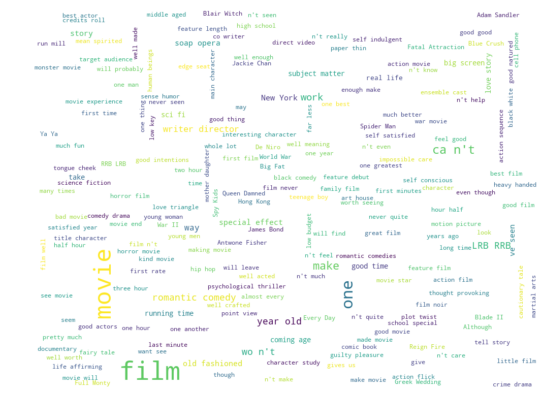

In [15]:
# wordcloud of complete training set
br.wordcloud_draw(X, color='white',max_words=200)

## TASK 1:
________________________________________________________________________________________________
Output confusion matrix, precision and recall values for the Kaggle Sentiment training data.

* Build a unigram MNB model and a unigram SVMs model.
* Print the top 10 indicative words for the most positive category and the most negative category from the MNB and SVMs models respectively. 
* You can change other parameters to your preference. Report your choice and explain why. 
* Report the confusion matrix, precisions, and recalls. Explain whether your models performed equally well on all categories, or some categories turn out to be easier or more difficult for MNB or SVMs. 
* Submit your revised script along with your report.

### Split train/test data for hold-out test
* 60/40 split ratio
* plot training/test label balance
* perform one-hot encoding on dataset labels
* initalize unigram CountVectorizer
* train vector on X_train content

#### Multinomial Naive Bayes Classification (MNB)
Python package scikit-learn v0.21.3 [sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.htm)


Naive Bayes classifier for multinomial models

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

Read more in the [User Guide](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes).

In [55]:
# Initialize a unigram vector object
t1_mnb_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,input='content',stop_words='english')
t1_svm_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,input='content',stop_words='english')

In [56]:
# Input parameter configurations
reportPath_task1 = f'{outputDir}/task1_models_report.txt'
cv=10
train_test_split_ratio=0.4
n_classes=len(np.unique(y))
v=2

Model Name:             task1_mnb_cnt_vec_unigram_v2


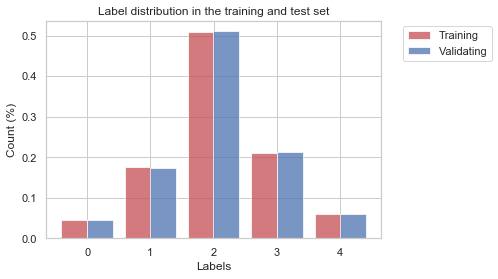

Vectorizer[count], category[task_1], version[2] --> transformed shape: (93636, 14643)
Vectorizer[count], category[task_1], version[2] --> transformed size: 342935
Vectorizer[count], category[task_1], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_1], version[2] --> vocabulary size: 14643
Vector Top 20 Head:
             feature  feature_index
14433     zzzzzzzzz          14642
13716         zwick          14641
9797         zucker          14640
12825          zoom          14639
11569     zoolander          14638
3457         zoning          14637
3343           zone          14636
13485        zombie          14635
13048           zoe          14634
13466          ziyi          14633
3922          zishe          14632
10868          zips          14631
5525          zippy          14630
10060        zipper          14629
10599           zip          14628
7115          zings          14627
9057        zingers          14626
133

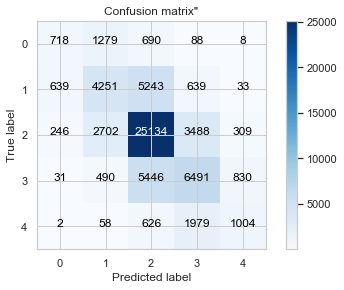

y_test head: [4 3 1 2 3 3 2 1 2 3]
model_pred head: [2 3 1 2 3 3 2 1 2 3]
               precision    recall  f1-score   support

very_negative       0.44      0.26      0.32      2783
     negative       0.48      0.39      0.43     10805
      neutral       0.68      0.79      0.73     31879
     positive       0.51      0.49      0.50     13288
very_positive       0.46      0.27      0.34      3669

    micro avg       0.60      0.60      0.60     62424
    macro avg       0.51      0.44      0.47     62424
 weighted avg       0.58      0.60      0.59     62424



In [57]:
# instantiate niave bayes models
mnb_clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

model_name = f'task1_mnb_cnt_vec_unigram_v{v}'

# perform core training and validation steps
mnb_test_pred_results = build_test_validate_models(t1_mnb_count_vec_unigram,
                                                   'mnb',
                                                   mnb_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task1,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

##### Print the top 10 indicative words for the most positive category and the most negative category
Interpret the trained model

##### Linear Support Vector Classification (LinearSVC)
Python package scikit-learn v0.21.3 [sklearn.svm.LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

Linear Support Vector Classification.

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

Read more in the [User Guide](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

**Interpreting LinearSVC models**
* LinearSVC uses a one-vs-all strategy to extend the binary SVM classifier to multi-class problems
* For the Kaggle sentiment classification problem, there are five categories 0,1,2,3,4 with 0 as very negative and 4 very positive
* LinearSVC builds five binary classifier, "very negative vs. others", "negative vs. others", "neutral vs. others", "positive vs. others", "very positive vs. others", and then pick the most confident prediction as the final prediction.
* Linear SVC also ranks all features based on their contribution to distinguish the two concepts in each binary classifier

Model Name:             task1_svm_cnt_vec_unigram_v2


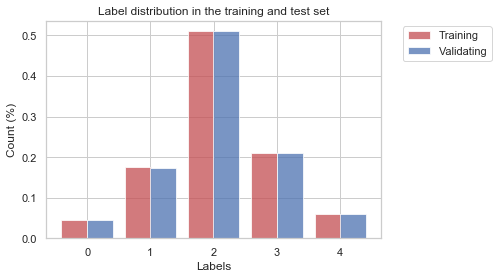

Vectorizer[count], category[task_1], version[2] --> transformed shape: (93636, 14668)
Vectorizer[count], category[task_1], version[2] --> transformed size: 344003
Vectorizer[count], category[task_1], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_1], version[2] --> vocabulary size: 14668
Vector Top 20 Head:
             feature  feature_index
13588     zzzzzzzzz          14667
3793          zwick          14666
13944        zucker          14665
455            zoom          14664
8761      zoolander          14663
7946         zoning          14662
1887           zone          14661
6658         zombie          14660
9429            zoe          14659
12542          ziyi          14658
6469          zishe          14657
10255          zips          14656
4111          zippy          14655
8489         zipper          14654
5633            zip          14653
6940          zings          14652
7168        zingers          14651
126

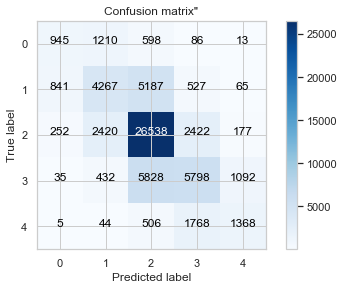

y_test head: [2 1 3 3 2 2 2 2 4 2]
model_pred head: [2 1 3 3 2 2 2 2 3 1]
               precision    recall  f1-score   support

very_negative       0.45      0.33      0.38      2852
     negative       0.51      0.39      0.44     10887
      neutral       0.69      0.83      0.75     31809
     positive       0.55      0.44      0.49     13185
very_positive       0.50      0.37      0.43      3691

    micro avg       0.62      0.62      0.62     62424
    macro avg       0.54      0.47      0.50     62424
 weighted avg       0.60      0.62      0.61     62424



In [58]:
# instantiate the LinearSVC model
svm_clf = LinearSVC(C=1)

model_name = f'task1_svm_cnt_vec_unigram_v{v}'

# perform core training and validation steps
svm_test_pred_results = build_test_validate_models(t1_svm_count_vec_unigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task1,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

## TASK 2:
________________________________________________________________________________________________
Consult the sklearn website to learn more about the CountVectorizer. Revise the script to build a MNB model and a SVMs model based on both unigram and bigram. For fair comparison, please keep the same 60% for training and the rest 40% for testing. Also keep your other vectorization parameters the same as in Task 1.

- Compare the confusion matrix and other evaluation measures (accuracy, precision, recall). Discuss whether adding bi-grams was helpful for sentiment classification, based on MNB and SVMs respectively.

In [59]:
# Initialize a unigram vector object
t2_mnb_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,input='content',stop_words='english')
t2_mnb_count_vec_bigram = br.inst_vectorizer('bigram','count',min_df=2,input='content',stop_words='english')

t2_svm_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,input='content',stop_words='english')
t2_svm_count_vec_bigram = br.inst_vectorizer('bigram','count',min_df=2,input='content',stop_words='english')

In [60]:
# Input parameter configurations
reportPath_task2 = f'{outputDir}/task2_models_report.txt'
cv=10
train_test_split_ratio=0.4
n_classes=len(np.unique(y))
v=2

Model Name:             task2_mnb_cnt_vec_unigram_v2


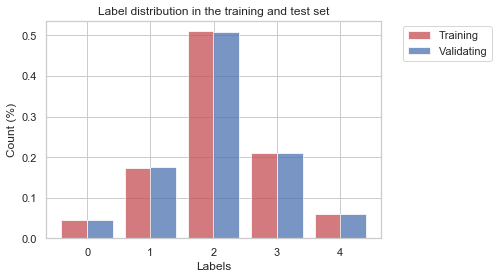

Vectorizer[count], category[task_2], version[2] --> transformed shape: (93636, 14685)
Vectorizer[count], category[task_2], version[2] --> transformed size: 342095
Vectorizer[count], category[task_2], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[2] --> vocabulary size: 14685
Vector Top 20 Head:
             feature  feature_index
13637     zzzzzzzzz          14684
7139          zwick          14683
5241         zucker          14682
1039      zoolander          14681
12477        zoning          14680
605            zone          14679
1741         zombie          14678
11571           zoe          14677
12785          ziyi          14676
9243          zishe          14675
12080          zips          14674
3410          zippy          14673
10349        zipper          14672
11242         zings          14671
6342        zingers          14670
10423        zinger          14669
9935   zhuangzhuang          14668
963

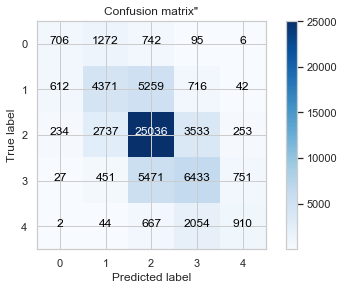

y_test head: [2 2 2 3 2 3 3 1 2 0]
model_pred head: [2 1 2 3 2 2 3 1 1 1]
               precision    recall  f1-score   support

very_negative       0.45      0.25      0.32      2821
     negative       0.49      0.40      0.44     11000
      neutral       0.67      0.79      0.73     31793
     positive       0.50      0.49      0.50     13133
very_positive       0.46      0.25      0.32      3677

    micro avg       0.60      0.60      0.60     62424
    macro avg       0.52      0.43      0.46     62424
 weighted avg       0.58      0.60      0.59     62424



In [61]:
## ----- MNB UNIGRAM ------ ##
mnb_clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

model_name = f'task2_mnb_cnt_vec_unigram_v{v}'

# perform core training and validation steps
mnb_unigram_test_pred_results = build_test_validate_models(t2_mnb_count_vec_unigram,
                                                   'mnb',
                                                   mnb_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task2_mnb_cnt_vec_bigram_v2


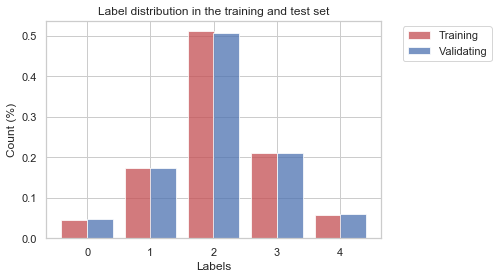

Vectorizer[count], category[task_2], version[2] --> transformed shape: (93636, 63904)
Vectorizer[count], category[task_2], version[2] --> transformed size: 589230
Vectorizer[count], category[task_2], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[2] --> vocabulary size: 63904
Vector Top 20 Head:
                  feature  feature_index
62261          zzzzzzzzz          63903
4550               zwick          63902
8719     zucker brothers          63901
8714              zucker          63900
11212  zoolander thought          63899
11209          zoolander          63898
32967  zoning ordinances          63897
32964             zoning          63896
6991   zone sympathizing          63895
5931           zone left          63894
38211         zone gives          63893
16262       zone equally          63892
57443       zone episode          63891
55835          zone bale          63890
21440         zone armed         

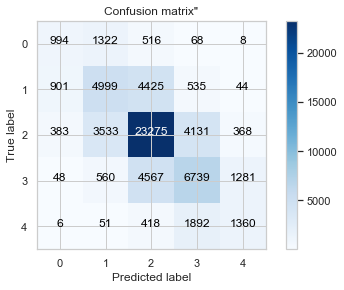

y_test head: [3 2 4 2 3 2 1 2 2 1]
model_pred head: [4 1 4 2 2 0 1 2 2 2]
               precision    recall  f1-score   support

very_negative       0.43      0.34      0.38      2908
     negative       0.48      0.46      0.47     10904
      neutral       0.70      0.73      0.72     31690
     positive       0.50      0.51      0.51     13195
very_positive       0.44      0.36      0.40      3727

    micro avg       0.60      0.60      0.60     62424
    macro avg       0.51      0.48      0.49     62424
 weighted avg       0.59      0.60      0.59     62424



In [62]:
## ----- MNB BIGRAM ------ ##
mnb_clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

model_name = f'task2_mnb_cnt_vec_bigram_v{v}'

# perform core training and validation steps
mnb_bigram_test_pred_results = build_test_validate_models(t2_mnb_count_vec_bigram,
                                                   'mnb',
                                                   mnb_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task2_svm_cnt_vec_unigram_v2


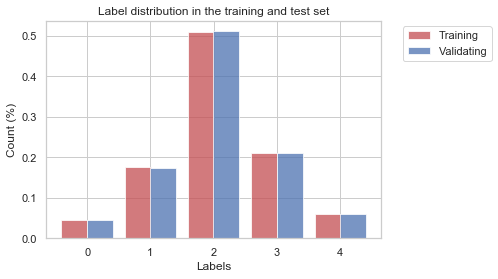

Vectorizer[count], category[task_2], version[2] --> transformed shape: (93636, 14655)
Vectorizer[count], category[task_2], version[2] --> transformed size: 342917
Vectorizer[count], category[task_2], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[2] --> vocabulary size: 14655
Vector Top 20 Head:
             feature  feature_index
11936     zzzzzzzzz          14654
2313          zwick          14653
10485        zucker          14652
13377     zoolander          14651
12899        zoning          14650
1776           zone          14649
7327         zombie          14648
11450           zoe          14647
14442          ziyi          14646
12321         zishe          14645
3694           zips          14644
4238          zippy          14643
11732        zipper          14642
13159           zip          14641
8355          zings          14640
1690        zingers          14639
11463        zinger          14638
138

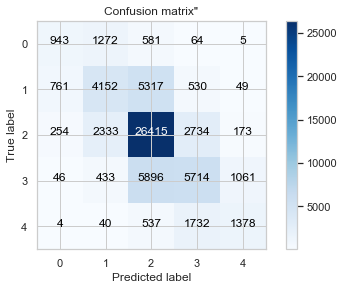

y_test head: [2 2 2 1 1 3 1 4 1 0]
model_pred head: [2 2 2 2 2 3 1 3 2 1]
               precision    recall  f1-score   support

very_negative       0.47      0.33      0.39      2865
     negative       0.50      0.38      0.44     10809
      neutral       0.68      0.83      0.75     31909
     positive       0.53      0.43      0.48     13150
very_positive       0.52      0.37      0.43      3691

    micro avg       0.62      0.62      0.62     62424
    macro avg       0.54      0.47      0.50     62424
 weighted avg       0.60      0.62      0.60     62424



In [63]:
## ----- SVM UNIGRAM ------ ##
svm_clf = LinearSVC(C=1)

model_name = f'task2_svm_cnt_vec_unigram_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t2_svm_count_vec_unigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task2_svm_cnt_vec_bigram_v2


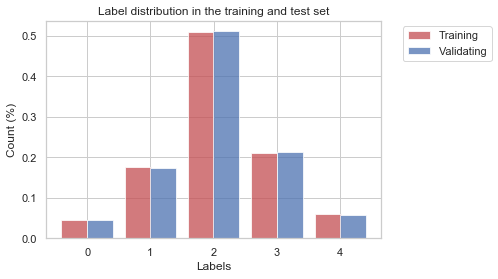

Vectorizer[count], category[task_2], version[2] --> transformed shape: (93636, 63719)
Vectorizer[count], category[task_2], version[2] --> transformed size: 589652
Vectorizer[count], category[task_2], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[2] --> vocabulary size: 63719
Vector Top 20 Head:
                  feature  feature_index
61095          zzzzzzzzz          63718
51361    zwick heartfelt          63717
35014              zwick          63716
4753     zucker brothers          63715
4739              zucker          63714
48380  zoolander thought          63713
48376          zoolander          63712
36556  zoning ordinances          63711
36554             zoning          63710
20931  zone sympathizing          63709
41635          zone left          63708
54728         zone gives          63707
27043       zone episode          63706
55293          zone bale          63705
41743         zone armed         

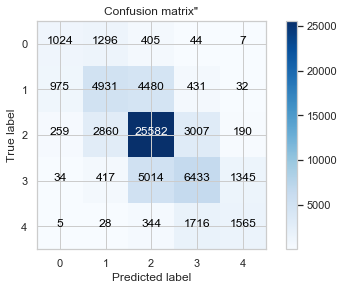

y_test head: [4 2 3 3 2 3 3 3 2 1]
model_pred head: [4 2 2 3 2 3 2 2 2 2]
               precision    recall  f1-score   support

very_negative       0.45      0.37      0.40      2776
     negative       0.52      0.45      0.48     10849
      neutral       0.71      0.80      0.76     31898
     positive       0.55      0.49      0.52     13243
very_positive       0.50      0.43      0.46      3658

    micro avg       0.63      0.63      0.63     62424
    macro avg       0.55      0.51      0.52     62424
 weighted avg       0.62      0.63      0.62     62424



In [64]:
## ----- SVM BIGRAM ------ ##
svm_clf = LinearSVC(C=1)

model_name = f'task2_svm_cnt_vec_bigram_v{v}'

# perform core training and validation steps
svm_bigram_test_pred_results = build_test_validate_models(t2_svm_count_vec_bigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

## TASK 3:
________________________________________________________________________________________________
Now revise the sample script to build your best SVMs model by tuning parameters and using the entire training data set (changing from 60% to 100%). Report what parameters you used to train the model, and its cross validation accuracy.

Then use this model to predict the Kaggle sentiment test data. Submit the prediction result to Kaggle, use screenshot to show your accuracy and ranking. 
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/submit

In [65]:
# Initialize a unigram vector object
t3_svm_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,input='content',stop_words='english')
t3_svm_count_vec_bigram = br.inst_vectorizer('bigram','count',min_df=2,input='content',stop_words='english')

In [66]:
# using gridsearch to tune SVC hyperparameters
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# one hot encoding for dataset labels
lbe = LabelEncoder()
y_train = lbe.fit_transform(y_train)
y_test = lbe.fit_transform(y_test)

train_vec = br.train_vector(logger, t3_svm_count_vec_unigram, X_train, category=None, v_type='count', version=1)
X_train_vec = train_vec[1]

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'loss': ['hinge','squared_hinge'], 
              }  
  
grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3) 

# fitting the model for grid search 
grid.fit(X_train_vec, y_train) 

Vectorizer[count], category[None], version[1] --> transformed shape: (140454, 14908)
Vectorizer[count], category[None], version[1] --> transformed size: 515435
Vectorizer[count], category[None], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[None], version[1] --> vocabulary size: 14908
Vector Top 20 Head:
             feature  feature_index
14900     zzzzzzzzz          14907
14097         zwick          14906
13739        zucker          14905
14769          zoom          14904
11657     zoolander          14903
7449         zoning          14902
1303           zone          14901
6914         zombie          14900
9054            zoe          14899
4081           ziyi          14898
6345          zishe          14897
10372          zips          14896
6278          zippy          14895
7215         zipper          14894
8081            zip          14893
2791          zings          14892
9068        zingers          14891
7928      

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.1, loss=hinge ...............................................
[CV] ...... C=0.1, loss=hinge, score=0.5961127723195215, total=   6.0s
[CV] C=0.1, loss=hinge ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] ...... C=0.1, loss=hinge, score=0.5975265923362809, total=   6.6s
[CV] C=0.1, loss=hinge ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.8s remaining:    0.0s


[CV] ...... C=0.1, loss=hinge, score=0.5966977101845523, total=   9.3s
[CV] C=0.1, loss=squared_hinge .......................................
[CV]  C=0.1, loss=squared_hinge, score=0.6238359675352414, total=   4.7s
[CV] C=0.1, loss=squared_hinge .......................................
[CV]  C=0.1, loss=squared_hinge, score=0.6234354308172071, total=   4.7s
[CV] C=0.1, loss=squared_hinge .......................................
[CV]  C=0.1, loss=squared_hinge, score=0.6235902255639098, total=   4.4s
[CV] C=1, loss=hinge .................................................
[CV] ........ C=1, loss=hinge, score=0.6288551900897053, total=  16.8s
[CV] C=1, loss=hinge .................................................
[CV] ........ C=1, loss=hinge, score=0.6248237857234397, total=  13.9s
[CV] C=1, loss=hinge .................................................
[CV] ........ C=1, loss=hinge, score=0.6300623718386876, total=  16.7s
[CV] C=1, loss=squared_hinge .........................................


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 22.5min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'loss': ['hinge', 'squared_hinge']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [67]:
# print best parameter after tuning 
logger.info(f'grid.best_params_: {grid.best_params_}') 
  
# print how our model looks after hyper-parameter tuning 
logger.info(f'grid.best_estimator_: {grid.best_estimator_}') 

grid.best_params_: {'C': 1, 'loss': 'hinge'}
grid.best_estimator_: LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [86]:
# Input parameter configurations
reportPath_task3 = f'{outputDir}/task3_models_report.txt'
cv=10
train_test_split_ratio=0.1
n_classes=len(np.unique(y))
v=4

Model Name:             task3_svm_cnt_vec_unigram_v3


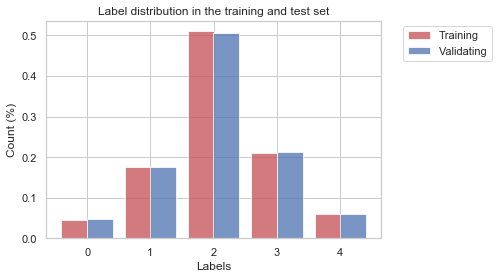

Vectorizer[count], category[task_3], version[3] --> transformed shape: (140454, 14911)
Vectorizer[count], category[task_3], version[3] --> transformed size: 515101
Vectorizer[count], category[task_3], version[3] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_3], version[3] --> vocabulary size: 14911
Vector Top 20 Head:
             feature  feature_index
14455     zzzzzzzzz          14910
3098          zwick          14909
9123         zucker          14908
14029          zoom          14907
6107      zoolander          14906
10204        zoning          14905
57             zone          14904
3103         zombie          14903
11164           zoe          14902
5773           ziyi          14901
3391          zishe          14900
10563          zips          14899
13430         zippy          14898
4643         zipper          14897
7016            zip          14896
1652          zings          14895
6932        zingers          14894
12

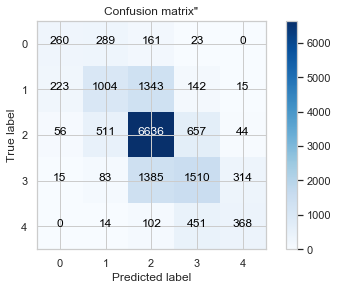

y_test head: [2 2 1 1 2 1 1 1 2 2]
model_pred head: [2 2 1 1 2 2 2 1 2 2]
               precision    recall  f1-score   support

very_negative       0.47      0.35      0.40       733
     negative       0.53      0.37      0.43      2727
      neutral       0.69      0.84      0.76      7904
     positive       0.54      0.46      0.50      3307
very_positive       0.50      0.39      0.44       935

    micro avg       0.63      0.63      0.63     15606
    macro avg       0.55      0.48      0.51     15606
 weighted avg       0.61      0.63      0.61     15606



In [69]:
## ----- SVM UNIGRAM ------ ##
svm_clf = LinearSVC(C=1,loss='hinge')

model_name = f'task3_svm_cnt_vec_unigram_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t3_svm_count_vec_unigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task3,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task3_svm_final_cnt_vec_bigram_v4


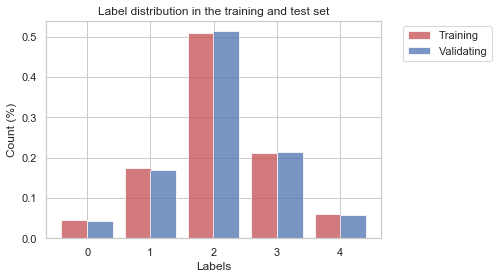

Vectorizer[count], category[task_3], version[4] --> transformed shape: (140454, 69560)
Vectorizer[count], category[task_3], version[4] --> transformed size: 891883
Vectorizer[count], category[task_3], version[4] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_3], version[4] --> vocabulary size: 69560
Vector Top 20 Head:
                  feature  feature_index
23489          zzzzzzzzz          69559
15792    zwick heartfelt          69558
15782              zwick          69557
23159    zucker brothers          69556
23152             zucker          69555
25925               zoom          69554
52840  zoolander thought          69553
49403          zoolander          69552
29055  zoning ordinances          69551
29053             zoning          69550
45085  zone sympathizing          69549
33870          zone left          69548
67365         zone gives          69547
60497       zone equally          69546
17673       zone episode        

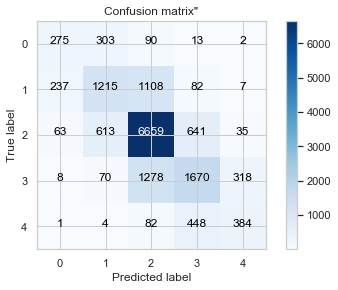

y_test head: [3 2 1 2 2 2 3 2 2 2]
model_pred head: [2 2 2 2 1 2 3 3 2 1]
               precision    recall  f1-score   support

very_negative       0.47      0.40      0.43       683
     negative       0.55      0.46      0.50      2649
      neutral       0.72      0.83      0.77      8011
     positive       0.59      0.50      0.54      3344
very_positive       0.51      0.42      0.46       919

    micro avg       0.65      0.65      0.65     15606
    macro avg       0.57      0.52      0.54     15606
 weighted avg       0.64      0.65      0.64     15606



In [87]:
## ----- SVM BIGRAM ------ ##
svm_clf_final = LinearSVC(C=1,loss='hinge')

model_name = f'task3_svm_final_cnt_vec_bigram_v{v}'

# perform core training and validation steps
svm_bigram_test_pred_results = build_test_validate_models(t3_svm_count_vec_bigram,
                                                   'svm',
                                                   svm_clf_final,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task3,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

## Task 4 - Create Models from best scorrers in HW6

In [71]:
# Initialize a unigram vector object
t4_svm_tfidf_vec_unigram_bool = br.inst_vectorizer('unigram','tfidf',min_df=2,input='content',stop_words='english', binary=True)
t4_svm_tfidf_vec_bigram_bool = br.inst_vectorizer('bigram','tfidf',min_df=2,input='content',stop_words='english', binary=True)

In [72]:
# Input parameter configurations
reportPath_task4 = f'{outputDir}/task4_models_report.txt'
cv=10
train_test_split_ratio=0.4
n_classes=len(np.unique(y))
v=2

Model Name:             task4_svm_tfidf_vec_unigram_bool_v2


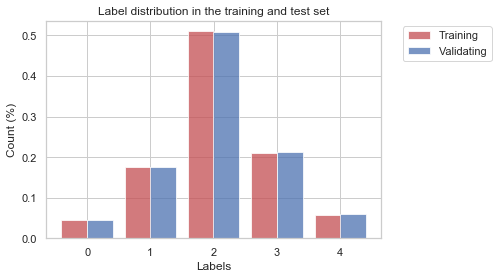

Vectorizer[tfidf], category[task_4], version[2] --> transformed shape: (93636, 14653)
Vectorizer[tfidf], category[task_4], version[2] --> transformed size: 343438
Vectorizer[tfidf], category[task_4], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[tfidf], category[task_4], version[2] --> vocabulary size: 14653
Vector Top 20 Head:
             feature  feature_index
12382     zzzzzzzzz          14652
13116         zwick          14651
5832         zucker          14650
11981     zoolander          14649
1961         zoning          14648
34             zone          14647
6948         zombie          14646
7870            zoe          14645
13151          ziyi          14644
5211          zishe          14643
12759          zips          14642
10207         zippy          14641
13716        zipper          14640
12894           zip          14639
9911          zings          14638
2230        zingers          14637
13623        zinger          14636
126

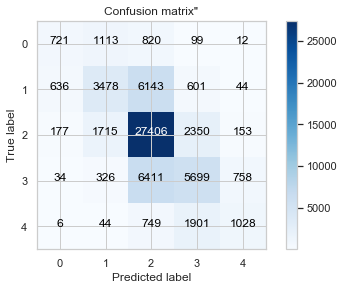

y_test head: [1 2 2 2 2 2 2 2 2 1]
model_pred head: [0 2 2 2 2 2 2 2 2 2]
               precision    recall  f1-score   support

very_negative       0.46      0.26      0.33      2765
     negative       0.52      0.32      0.40     10902
      neutral       0.66      0.86      0.75     31801
     positive       0.54      0.43      0.48     13228
very_positive       0.52      0.28      0.36      3728

    micro avg       0.61      0.61      0.61     62424
    macro avg       0.54      0.43      0.46     62424
 weighted avg       0.59      0.61      0.59     62424



In [73]:
## ----- SVM UNIGRAM BOOL------ ##
svm_clf = LinearSVC(C=1,loss='hinge')

model_name = f'task4_svm_tfidf_vec_unigram_bool_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t4_svm_tfidf_vec_unigram_bool,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task4,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task4_svm_tfidf_vec_bigram_bool_v2


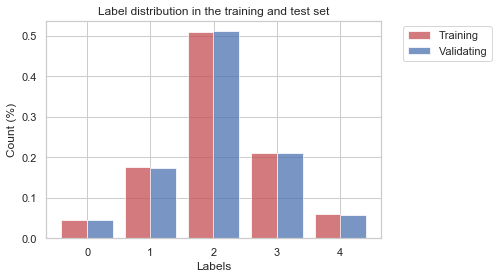

Vectorizer[tfidf], category[task_4], version[2] --> transformed shape: (93636, 63837)
Vectorizer[tfidf], category[task_4], version[2] --> transformed size: 589609
Vectorizer[tfidf], category[task_4], version[2] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[tfidf], category[task_4], version[2] --> vocabulary size: 63837
Vector Top 20 Head:
                  feature  feature_index
59590          zzzzzzzzz          63836
39756              zwick          63835
24526    zucker brothers          63834
24521             zucker          63833
36489  zoolander thought          63832
1164           zoolander          63831
51360  zoning ordinances          63830
51358             zoning          63829
17232  zone sympathizing          63828
4908           zone left          63827
23280         zone gives          63826
13397       zone episode          63825
22071          zone bale          63824
16452      zone attempts          63823
8698          zone armed         

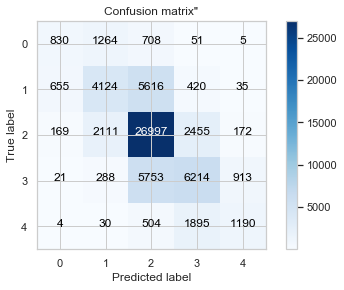

y_test head: [2 2 1 2 2 2 3 2 2 2]
model_pred head: [2 2 1 2 1 2 2 2 2 2]
               precision    recall  f1-score   support

very_negative       0.49      0.29      0.37      2858
     negative       0.53      0.38      0.44     10850
      neutral       0.68      0.85      0.76     31904
     positive       0.56      0.47      0.51     13189
very_positive       0.51      0.33      0.40      3623

    micro avg       0.63      0.63      0.63     62424
    macro avg       0.56      0.46      0.50     62424
 weighted avg       0.61      0.63      0.61     62424



In [74]:
## ----- SVM BIGRAM BOOL------ ##
svm_clf = LinearSVC(C=1,loss='hinge')

model_name = f'task4_svm_tfidf_vec_bigram_bool_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t4_svm_tfidf_vec_bigram_bool,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task4,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

### Evaluate Model Results

In [75]:
# build summary report df
summary_report_df = pd.DataFrame()

summary_report_df['Model_Type'] = model_types
summary_report_df['Category'] = categories
summary_report_df['Vectorizer'] = vectorizers
summary_report_df['N_Gram'] = ngrams
summary_report_df['Experiment_Model_Name'] = exp_model_names
summary_report_df['Dataset_Version'] = dataset_versions
summary_report_df['Cross_Folds'] = cross_folds
summary_report_df['Prediction_Accuracy'] = prediction_accuracys
summary_report_df['Total_Prediction_Points'] = total_prediction_points
summary_report_df['Test_Recall_Score_Avg'] = test_recall_score_avgs
summary_report_df['Test_Precision_Score_Avg'] = test_precision_score_avgs
summary_report_df['Train_Recall_Score_Avg'] = train_recall_score_avgs
summary_report_df['Train_Precision_Score_Avg'] = train_precision_score_avgs
summary_report_df['Total_Build_Time'] = total_build_times
summary_report_df['Total_Predict_Time'] = total_predict_time
summary_report_df['Confusion_Matrix'] = confusion_matrixs

summary_report_df.head(10)

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
0,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v1,v1,10,60.35,62424,0.4362,0.5130,0.5283,0.6360,1.0055,0.0152,[[ 686 1266 762 92 14]\n [ 624 410...
1,LinearSVM,task_1,count,unigram,task1_svm_cnt_vec_unigram_v1,v1,10,62.01,62424,0.4683,0.5398,0.6174,0.7269,321.9631,0.0137,[[ 917 1157 672 68 10]\n [ 790 394...
2,Multinomial_Naive_Bayes,task_2,count,unigram,task2_mnb_cnt_vec_unigram_v1,v1,10,60.25,62424,0.4354,0.5097,0.5277,0.6352,1.0281,0.0152,[[ 665 1267 776 98 14]\n [ 592 415...
3,Multinomial_Naive_Bayes,task_2,count,bigram,task2_mnb_cnt_vec_bigram_v1,v1,10,59.11,62424,0.4680,0.4893,0.5857,0.6258,1.2975,0.0210,[[ 784 1266 682 77 16]\n [ 835 435...
4,LinearSVM,task_2,count,unigram,task2_svm_cnt_vec_unigram_v1,v1,10,61.97,62424,0.4641,0.5356,0.6156,0.7245,397.0770,0.0150,[[ 886 1185 668 79 14]\n [ 802 396...
5,LinearSVM,task_2,count,bigram,task2_svm_cnt_vec_bigram_v1,v1,10,63.05,62424,0.4948,0.5392,0.7301,0.7988,542.1016,0.0172,[[ 1017 1207 534 52 10]\n [ 965 461...
6,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v2,v2,10,62.64,62424,0.4662,0.5299,0.5968,0.6938,141.7423,0.0227,[[ 980 1105 643 95 8]\n [ 861 375...
7,LinearSVM,task_3,count,bigram,task3_svm_cnt_vec_bigram_v2,v2,10,62.82,62424,0.4932,0.5436,0.6834,0.7618,262.4704,0.0150,[[ 995 1208 533 76 18]\n [ 881 421...
8,LinearSVM,task_4,tfidf,unigram,task4_svm_tfidf_vec_unigram_bool_v1,v1,10,61.24,62424,0.4249,0.5363,0.5163,0.6650,98.8090,0.0089,[[ 721 1107 923 119 5]\n [ 581 339...
9,LinearSVM,task_4,tfidf,bigram,task4_svm_tfidf_vec_bigram_bool_v1,v1,10,62.27,62424,0.4524,0.5499,0.5925,0.7226,199.8258,0.0160,[[ 731 1196 760 92 17]\n [ 594 392...


In [89]:
sorted_summary_report = summary_report_df.sort_values(by=['Prediction_Accuracy','Experiment_Model_Name'], ascending=False)
sorted_summary_report

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
19,LinearSVM,task_3,count,bigram,task3_svm_cnt_vec_bigram_v3,v3,10,65.61,15606,0.5262,0.5667,0.7297,0.7970,578.3561,0.0031,[[ 277 334 90 11 3]\n [ 232 1260 1098 ...
11,LinearSVM,task_3,count,bigram,task3_svm_cnt_vec_bigram_v1,v1,10,64.35,15606,0.5194,0.5646,0.6914,0.7604,617.0646,0.0034,[[ 277 330 100 14 6]\n [ 225 1177 1168 ...
17,LinearSVM,task_2,count,bigram,task2_svm_cnt_vec_bigram_v2,v2,10,63.33,62424,0.5089,0.5383,0.8168,0.8601,482.1774,0.0135,[[ 1024 1296 405 44 7]\n [ 975 493...
5,LinearSVM,task_2,count,bigram,task2_svm_cnt_vec_bigram_v1,v1,10,63.05,62424,0.4948,0.5392,0.7301,0.7988,542.1016,0.0172,[[ 1017 1207 534 52 10]\n [ 965 461...
21,LinearSVM,task_4,tfidf,bigram,task4_svm_tfidf_vec_bigram_bool_v2,v2,10,63.04,62424,0.4655,0.5607,0.6553,0.7767,191.6706,0.0124,[[ 830 1264 708 51 5]\n [ 655 412...
10,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v1,v1,10,63.03,15606,0.4842,0.5496,0.5839,0.6764,307.6395,0.0028,[[ 256 309 126 18 4]\n [ 197 1065 1383 ...
7,LinearSVM,task_3,count,bigram,task3_svm_cnt_vec_bigram_v2,v2,10,62.82,62424,0.4932,0.5436,0.6834,0.7618,262.4704,0.0150,[[ 995 1208 533 76 18]\n [ 881 421...
18,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v3,v3,10,62.66,15606,0.4874,0.5517,0.5926,0.6823,275.5604,0.0022,[[ 260 289 161 23 0]\n [ 223 1004 1343 ...
6,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v2,v2,10,62.64,62424,0.4662,0.5299,0.5968,0.6938,141.7423,0.0227,[[ 980 1105 643 95 8]\n [ 861 375...
13,LinearSVM,task_1,count,unigram,task1_svm_cnt_vec_unigram_v2,v2,10,62.34,62424,0.4733,0.5374,0.6409,0.7422,384.4939,0.0109,[[ 945 1210 598 86 13]\n [ 841 426...


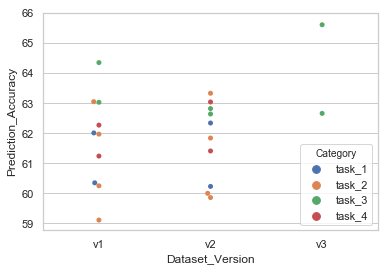

In [77]:
sns.swarmplot(x='Dataset_Version',y='Prediction_Accuracy',hue='Category',data=summary_report_df)

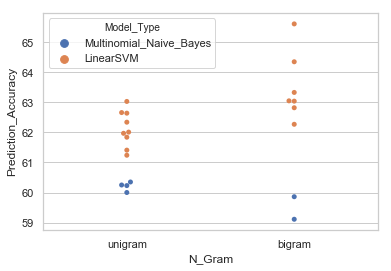

In [85]:
sns.swarmplot(x='N_Gram',y='Prediction_Accuracy',hue='Model_Type',data=summary_report_df)

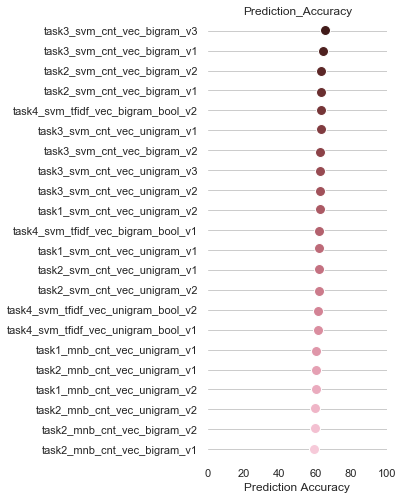

In [78]:
sns.set(style="whitegrid")
g = sns.PairGrid(sorted_summary_report,x_vars='Prediction_Accuracy', 
                 y_vars=['Experiment_Model_Name'], height=7, aspect=.50)

#Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 100), xlabel="Prediction Accuracy", ylabel="")


# Use semantically meaningful titles for the columns
titles = ["Prediction_Accuracy"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [79]:
sorted_summary_report_v1 = summary_report_df.sort_values(by=['Dataset_Version','Prediction_Accuracy'], ascending=False)
sorted_summary_report_v1.head(10)

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
19,LinearSVM,task_3,count,bigram,task3_svm_cnt_vec_bigram_v3,v3,10,65.61,15606,0.5262,0.5667,0.7297,0.7970,578.3561,0.0031,[[ 277 334 90 11 3]\n [ 232 1260 1098 ...
18,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v3,v3,10,62.66,15606,0.4874,0.5517,0.5926,0.6823,275.5604,0.0022,[[ 260 289 161 23 0]\n [ 223 1004 1343 ...
17,LinearSVM,task_2,count,bigram,task2_svm_cnt_vec_bigram_v2,v2,10,63.33,62424,0.5089,0.5383,0.8168,0.8601,482.1774,0.0135,[[ 1024 1296 405 44 7]\n [ 975 493...
21,LinearSVM,task_4,tfidf,bigram,task4_svm_tfidf_vec_bigram_bool_v2,v2,10,63.04,62424,0.4655,0.5607,0.6553,0.7767,191.6706,0.0124,[[ 830 1264 708 51 5]\n [ 655 412...
7,LinearSVM,task_3,count,bigram,task3_svm_cnt_vec_bigram_v2,v2,10,62.82,62424,0.4932,0.5436,0.6834,0.7618,262.4704,0.0150,[[ 995 1208 533 76 18]\n [ 881 421...
6,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v2,v2,10,62.64,62424,0.4662,0.5299,0.5968,0.6938,141.7423,0.0227,[[ 980 1105 643 95 8]\n [ 861 375...
13,LinearSVM,task_1,count,unigram,task1_svm_cnt_vec_unigram_v2,v2,10,62.34,62424,0.4733,0.5374,0.6409,0.7422,384.4939,0.0109,[[ 945 1210 598 86 13]\n [ 841 426...
16,LinearSVM,task_2,count,unigram,task2_svm_cnt_vec_unigram_v2,v2,10,61.84,62424,0.4737,0.5425,0.6400,0.7449,358.4306,0.0141,[[ 943 1272 581 64 5]\n [ 761 415...
20,LinearSVM,task_4,tfidf,unigram,task4_svm_tfidf_vec_unigram_bool_v2,v2,10,61.41,62424,0.4252,0.5373,0.5262,0.6753,82.0942,0.0087,[[ 721 1113 820 99 12]\n [ 636 347...
12,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v2,v2,10,60.23,62424,0.4354,0.5134,0.5339,0.6439,1.2232,0.0136,[[ 718 1279 690 88 8]\n [ 639 425...


In [80]:
# avg prediciton by data version
v4_avg = summary_report_df[summary_report_df['Dataset_Version']=='v4'].Prediction_Accuracy.mean()
logger.info(f'V4 Avg Prediciton Accuracy: {v4_avg}')
v3_avg = summary_report_df[summary_report_df['Dataset_Version']=='v3'].Prediction_Accuracy.mean()
logger.info(f'V3 Avg Prediciton Accuracy: {v3_avg}')
v2_avg = summary_report_df[summary_report_df['Dataset_Version']=='v2'].Prediction_Accuracy.mean()
logger.info(f'V2 Avg Prediciton Accuracy: {v2_avg}')
v1_avg = summary_report_df[summary_report_df['Dataset_Version']=='v1'].Prediction_Accuracy.mean()
logger.info(f'V1 Avg Prediciton Accuracy: {v1_avg}')

# avg prediction by n_gram
unigram_avg = summary_report_df[summary_report_df['N_Gram']=='unigram'].Prediction_Accuracy.mean()
logger.info(f'unigram_avg Prediciton Accuracy: {unigram_avg}')
bigram_avg = summary_report_df[summary_report_df['N_Gram']=='bigram'].Prediction_Accuracy.mean()
logger.info(f'bigram_avg Prediciton Accuracy: {bigram_avg}')



V4 Avg Prediciton Accuracy: nan
V3 Avg Prediciton Accuracy: 64.13499999999999
V2 Avg Prediciton Accuracy: 61.751
V1 Avg Prediciton Accuracy: 61.76300000000001
unigram_avg Prediciton Accuracy: 61.53615384615385
bigram_avg Prediciton Accuracy: 62.604444444444454


In [81]:
mnb_df = summary_report_df[summary_report_df['Model_Type']=='Multinomial_Naive_Bayes']
mnb_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
0,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v1,v1,10,60.35,62424,0.4362,0.5130,0.5283,0.6360,1.0055,0.0152,[[ 686 1266 762 92 14]\n [ 624 410...
2,Multinomial_Naive_Bayes,task_2,count,unigram,task2_mnb_cnt_vec_unigram_v1,v1,10,60.25,62424,0.4354,0.5097,0.5277,0.6352,1.0281,0.0152,[[ 665 1267 776 98 14]\n [ 592 415...
12,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v2,v2,10,60.23,62424,0.4354,0.5134,0.5339,0.6439,1.2232,0.0136,[[ 718 1279 690 88 8]\n [ 639 425...
14,Multinomial_Naive_Bayes,task_2,count,unigram,task2_mnb_cnt_vec_unigram_v2,v2,10,60.00,62424,0.4307,0.5053,0.5290,0.6407,1.1623,0.0092,[[ 706 1272 742 95 6]\n [ 612 437...
15,Multinomial_Naive_Bayes,task_2,count,bigram,task2_mnb_cnt_vec_bigram_v2,v2,10,59.86,62424,0.4924,0.5036,0.6469,0.6812,1.6675,0.0465,[[ 994 1322 516 68 8]\n [ 901 499...


In [82]:
# save summary report
save_as = f'{outputDir}/summary_report.csv'
summary_report_df.to_csv(save_as,index=False)

## Model Prediction
Perform model prediction

### Kaggle Test set Preduction and submission

In [88]:
# read in the test data
kaggle_test= test_final_submission

# preserve the id column of the test examples
kaggle_ids=kaggle_test['PhraseId'].values

# read in the text content of the examples
kaggle_X_test=kaggle_test['Phrase'].values

svm_final_count_vec_bigram = br.inst_vectorizer('bigram','count',min_df=2,input='content',stop_words='english')

X_train_vec = svm_final_count_vec_bigram.fit_transform(X)
X_test_vec = svm_final_count_vec_bigram.transform(kaggle_X_test)

# one hot encoding for dataset labels
lbe = LabelEncoder()
y_train = lbe.fit_transform(y)

# predict using the NB classifier that we built
kaggle_pred=svm_clf_final.fit(X_train_vec, y_train).predict(X_test_vec)

# combine the test example ids with their predictions
kaggle_submission=zip(kaggle_ids, kaggle_pred)

# prepare output file
outf=open(f'{outputDir}/kaggle_submission_linearSVC_tf.csv', 'w')

# write header
outf.write('PhraseId,Sentiment\n')

# write predictions with ids to the output file
for x, value in enumerate(kaggle_submission): outf.write(str(value[0]) + ',' + str(value[1]) + '\n')

# close the output file
outf.close()
# Your code ends here

# Report Generation
Execute the below cell to create an HTML report

In [84]:
# for report auto generation
# testing markup report generation
#from nbconvert import HTMLExporter
#import codecs
#import os
#import datetime

#stamp = datetime.date.today().strftime("%m-%d-%Y")
#exporter = HTMLExporter(template_file='report.tpl')
#output, resources = exporter.from_filename(notebook_file_name)
#new_fnw = report_file_name
#codecs.open(new_fnw, 'w',encoding='utf-8').write(output)